In [2]:
# Імпортуємо потрібні нам бібліотеки
import pandas as pd
import numpy as np
import os # Для роботи з файловою системою(отримання списку папок, побудова шляхів)
import glob # Для пошуку папок за шаблоном(наприклад, знайти всі .csv)

In [4]:
# Налаштування шляхів та параметрів
base_path = os.path.join('homework', 'data')
# Перевірка шляху та чи ми можемо знайти папки
try:
    activity_folders = os.listdir(base_path)
    print(f"Знайдено папки з активностями: {activity_folders}")
except FileNotFoundError:
    print(f"Не знайдено папку з даними за шляхом - '{os.path.abspath(base_path)}'")

Знайдено папки з активностями: ['idle', 'running', 'stairs', 'walking']


In [5]:
# Створюємо порожній список, де будемо тимчасово зберігати дані з кожного файлу
all_data_list = []

# Перевіряємо, чи ми знайшли хоча б одну папку, перш ніж запускати цикл
if activity_folders:
    # Проходимо по кожній назві папки, яку ми знайшли (walking, stairs і т.д.)
    for activity in activity_folders:
        activity_path = os.path.join(base_path, activity) # Створюємо повний шлях до папки активності

        # Перевіряємо, що це дійсно папка, а не якийсь випадковий файл
        if os.path.isdir(activity_path):
            # Знаходимо всі файли, що закінчуються на .csv, всередині поточної папки 
            files_to_read = glob.glob(os.path.join(activity_path, '*.csv'))
            print(f"Обробка активності '{activity}'. Знайдено {len(files_to_read)} файлів.")

            # Тепер проходимо по кожному знайденому файлу
            for file_path in files_to_read:
                try:
                    # header=None: кажемо pandas, що в файлі немає рядка з назвами колонок
                    # names=[...]: надаємо власні назви для колонок
                    temp_df = pd.read_csv(file_path, header=None, names=['accel_x', 'accel_y', 'accel_z'])
                    # Створюємо новий стовпець 'activity' і записуємо в нього назву папки
                    temp_df['activity'] = activity
                    # Додаємо щойно прочитаний та збагачений DataFrame до нашого загального списку
                    all_data_list.append(temp_df)
                except Exception as e:
                    print(f"Не вдалося прочитати файл {os.path.basename(file_path)}: {e}")

Обробка активності 'idle'. Знайдено 1039 файлів.
Обробка активності 'running'. Знайдено 3408 файлів.
Обробка активності 'stairs'. Знайдено 165 файлів.
Обробка активності 'walking'. Знайдено 1850 файлів.


In [17]:
# Фінальне об'єднання
# pd.concat бере список з DataFrame'ів і ефективно "склеює" їх один під одним
# ignore_index=True створює новий, чистий індекс для фінальної таблиці (від 0 до N-1)
df = pd.concat(all_data_list, ignore_index=True)

# Вибираємо стовпці, які мають бути числами
cols_to_convert = ['accel_x', 'accel_y', 'accel_z']

for col in cols_to_convert:
    # pd.to_numeric намагається перетворити кожен елемент на число.
    # errors='coerce': Якщо якийсь елемент не можна перетворити
    # (наприклад, там текст), він буде замінений на `NaN` (Not a Number).
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Тепер варто перевірити, чи не з'явилися у нас пропущені значення (NaN)
# Це покаже, чи були в даних "погані" записи
print(f"Кількість пропущених значень після перетворення:")
print(df.isnull().sum())

# (Опціонально, але рекомендовано) Видаляємо рядки з пропущеними значеннями
# оскільки вони можуть створювати проблеми для моделей
original_rows = len(df)
df.dropna(inplace=True)
print(f"Видалено {original_rows - len(df)} рядків з пропущеними значеннями.")
# Виведемо трохи інформації
df.info()

Кількість пропущених значень після перетворення:
accel_x     6462
accel_y     6462
accel_z     6462
activity       0
dtype: int64
Видалено 6462 рядків з пропущеними значеннями.
<class 'pandas.core.frame.DataFrame'>
Index: 193860 entries, 1 to 200321
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   accel_x   193860 non-null  float64
 1   accel_y   193860 non-null  float64
 2   accel_z   193860 non-null  float64
 3   activity  193860 non-null  object 
dtypes: float64(3), object(1)
memory usage: 7.4+ MB


In [16]:
# Перші 5 рядків даних 
df.head()

,accel_x,accel_y,accel_z,activity
1,1.000776,4.616021,8.576031,idle
2,0.718261,4.209007,8.446744,idle
3,-0.909797,-0.282516,9.203311,idle
4,5.099650,0.148441,8.418014,idle
5,1.762132,-0.162806,9.251195,idle


In [18]:
# Останні 5 рядків даних (перевірка, що дані з різних папок завантажились)
df.tail()

,accel_x,accel_y,accel_z,activity
200317,5.109226,-15.452178,-1.470040,walking
200318,6.373365,-11.741165,-8.226476,walking
200319,3.289633,-9.993398,-0.383072,walking
200320,-2.978387,-3.050213,1.273715,walking
200321,-4.347870,-9.926360,-1.642422,walking


In [19]:
# Розподіл даних по активностях
df['activity'].value_counts()

activity
running    102240
walking     55500
idle        31170
stairs       4950
Name: count, dtype: int64

In [20]:
# Імпортуємо бібліотеки для візуалізації
import matplotlib.pyplot as plt
import seaborn as sns

# Налаштування стилю графіків
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('seaborn-v0_8-whitegrid') # Використовуємо один з вбудованих стилів

# Візуалізація сигналів для кожної активності
activities = df['activity'].unique()
print(f"Активності для візуалізації {activities}")

Активності для візуалізації ['idle' 'running' 'stairs' 'walking']


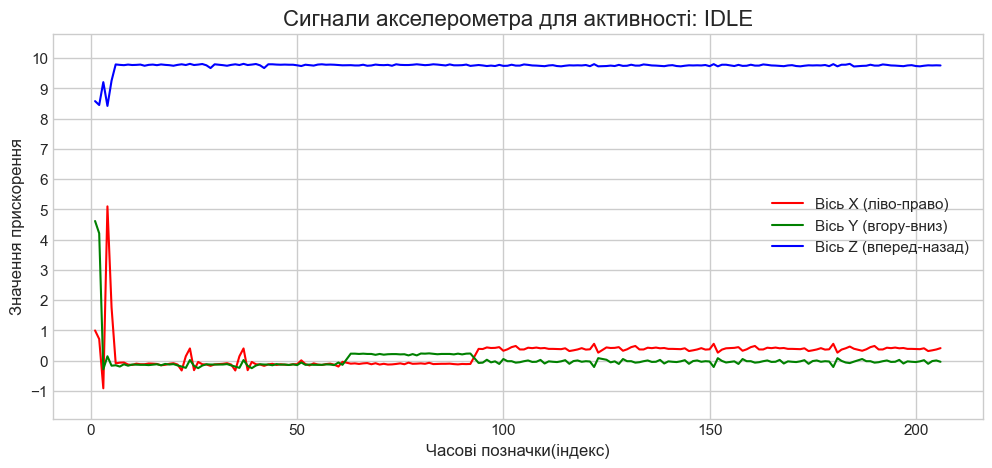

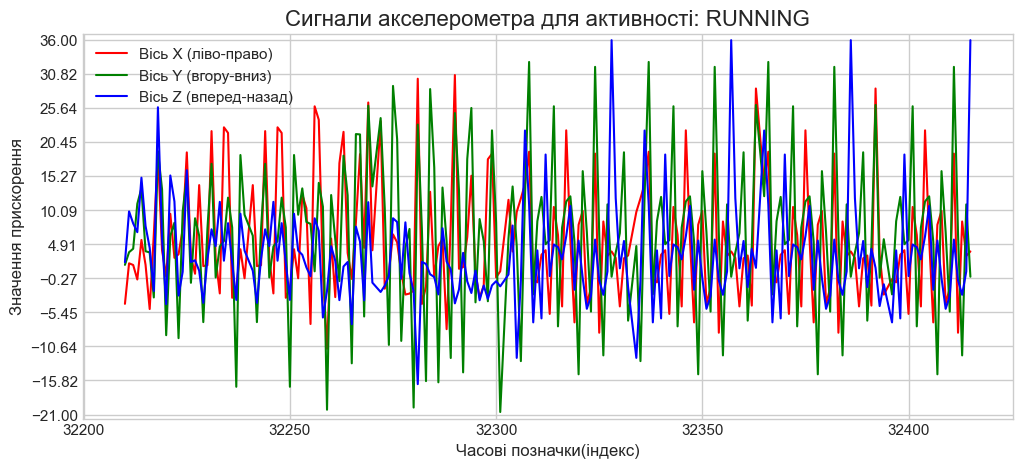

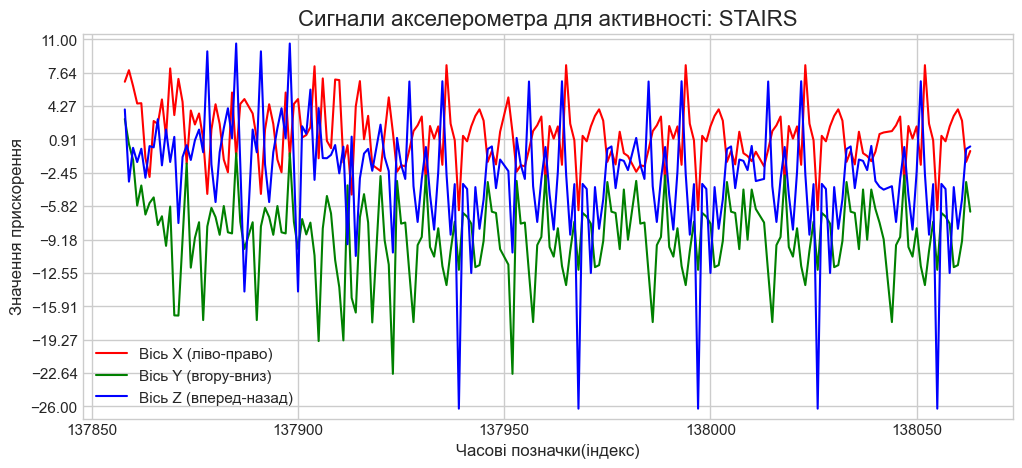

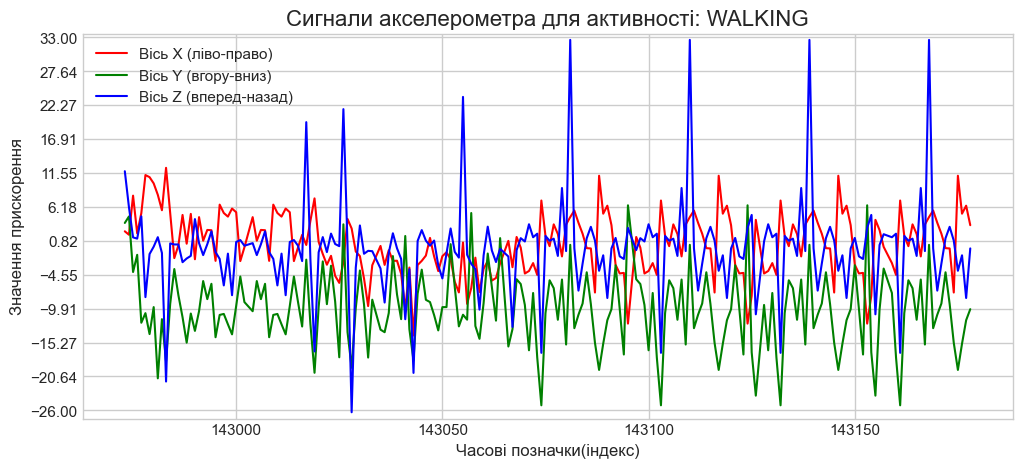

In [21]:
# Створюємо цикл, щоб побудувати окремий графік для кожної активності
for activity in activities:
    
    # Вибираємо під-набір даних, що містять поточну активність
    subset = df[df['activity'] == activity].head(200) # Беремо перші 200 точок, щоб графік не був перевантаженим
    
    # Створюємо полотно для нашого графіка
    plt.figure(figsize=(12, 5)) # Розмір графіка(ширина, висота в дюймах)
    
    # Малюємо лінії для кожної осі акселерометра
    plt.plot(subset.index, subset['accel_x'], label='Вісь X (ліво-право)', color='red', linewidth=1.5)
    plt.plot(subset.index, subset['accel_y'], label='Вісь Y (вгору-вниз)', color='green', linewidth=1.5)
    plt.plot(subset.index, subset['accel_z'], label='Вісь Z (вперед-назад)', color='blue', linewidth=1.5)
    
    # Знаходимо мінімальне і максимальне значення по всіх трьох осях, щоб встановити межі
    all_values = pd.concat([subset['accel_x'], subset['accel_y'], subset['accel_z']])
    min_val = all_values.min()
    max_val = all_values.max()
    
    # Встановлюємо межі для осі Y з невеликим відступом, щоб графік не притискався до країв
    plt.ylim(min_val - 1, max_val + 1)
    
    # matplotlib створює 10-15 красивих міток на осі Y, рівномірно розподілених
    # np.linspace() - створює рівномірний діапазон чисел
    num_ticks = 12
    plt.yticks(np.linspace(round(min_val), round(max_val), num_ticks)) 
    
    # Додаємо інформативні підписи
    plt.title(f"Сигнали акселерометра для активності: {activity.upper()}", fontsize=16)
    plt.xlabel('Часові позначки(індекс)', fontsize=12)
    plt.ylabel('Значення прискорення', fontsize=12)
    plt.legend() # Пояснення, яка лінія за що відповідає
    plt.grid(True) # Вмикаємо сітку
    
    # Показуємо графік
    plt.show()
    

In [28]:
# Імпортуємо додаткові інструменти
from scipy.stats import iqr, skew, kurtosis # Імпортуємо більше статистичних функцій

# Функція для розрахунку ознак, для одного вікна
def get_time_domain_features(segment):
    """
    Розраховує набір часових ознак для переданого сегменту (вікна) даних.
    Сегмент - це невеликий DataFrame з колонками 'accel_x', 'accel_y', 'accel_z'.
    """
    features = {}
    
    # Розраховуємо ознаки для кожної осі
    for axis in ['accel_x', 'accel_y', 'accel_z']:
        signal = segment[axis]
        
        # Основні статистичні показники
        features[f'{axis}_mean'] = signal.mean()        # Середнє
        features[f'{axis}_std'] = signal.std()          # Стандартне відхилення
        features[f'{axis}_var'] = signal.var()          # Дисперсія
        features[f'{axis}_min'] = signal.min()          # Мінімальне значення
        features[f'{axis}_max'] = signal.max()          # Максимальне значення
        features[f'{axis}_median'] = signal.median()    # Медіана
        features[f'{axis}_range'] = signal.max() - signal.min() # Розмах
        features[f'{axis}_iqr'] = iqr(signal)           # Міжквартильний розмах
        features[f'{axis}_mad'] = (np.abs(signal - signal.mean())).mean()          # Середнє абсолютне відхилення
        features[f'{axis}_skew'] = skew(signal)         # Асиметрія
        features[f'{axis}_kurt'] = kurtosis(signal)     # Ексцес
        
        # Ознаки, пов'язані з енергією
        features[f'{axis}_rms'] = np.sqrt(np.mean(signal**2)) # Root Mean Square
        features[f'{axis}_energy'] = np.sum(signal**2)       # Енергія сигналу
    
    # Додамо перехресну кореляцію між осями (як у статті)
    features['xy_corr'] = segment['accel_x'].corr(segment['accel_y'])
    features['xz_corr'] = segment['accel_x'].corr(segment['accel_z'])
    features['yz_corr'] = segment['accel_y'].corr(segment['accel_z'])
        
    return features

In [29]:
# Функція для створення датасету з ознаками "Ковзне вікно"
def create_features_from_windows(data, window_size, step_size):
    """
    Створює датасет з ознаками, використовуючи метод ковзного вікна.
    """
    feature_list = [] # Список для словників з ознаками
    label_list = []   # Список для міток
    
    # Рухаємося по всьому датасету з заданим кроком
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        
        # Розраховуємо ознаки для поточного вікна
        features = get_time_domain_features(window)
        feature_list.append(features)
        
        # Мітка для вікна - це найпоширеніша активність у цьому вікні
        # Це надійний спосіб, якщо вікно потрапляє на межу двох активностей
        label = window['activity'].mode()[0]
        label_list.append(label)
        
    # Перетворюємо список словників на DataFrame
    features_df = pd.DataFrame(feature_list)
    # Перетворюємо список міток на об'єкт Series
    labels_series = pd.Series(label_list, name='activity')
    
    return features_df, labels_series


In [30]:
# Параметри вікна (ці числа можна змінювати для експериментів)
# WINDOW_SIZE = 128 - часто використовують степені двійки
# Спробуємо 100, як і раніше, це ~2 секунди при частоті 50Hz, що є добрим показником.
WINDOW_SIZE = 100 
STEP_SIZE = 50   # 50% перекриття між вікнами - стандартна практика

print(f"   Розмір вікна: {WINDOW_SIZE}, Крок: {STEP_SIZE}")

# Викликаємо нашу головну функцію, яку ми щойно створили.
# Вона повертає два об'єкти: таблицю з ознаками (X) і стовпець з мітками (y)
X_features, y_features = create_features_from_windows(df, WINDOW_SIZE, STEP_SIZE)
X_features.fillna(0, inplace=True)

print("Розмір нового датасету з ознаками (X_features):", X_features.shape)
print("Кількість міток (y_features):", len(y_features))

print("Розподіл класів у фінальному наборі даних:")
print(y_features.value_counts())

   Розмір вікна: 100, Крок: 50
Розмір нового датасету з ознаками (X_features): (3876, 42)
Кількість міток (y_features): 3876
Розподіл класів у фінальному наборі даних:
activity
running    2045
walking    1109
idle        623
stairs       99
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split
# X - це наші ознаки, y - це наша цільова змінна (активність)
# test_size=0.3: 30% даних піде в тестову вибірку, 70% - в тренувальну.
# random_state=42: гарантує, що розділення буде однаковим при кожному запуску коду.
# stratify=y_features: гарантує, що у тренувальній
#                      та тестовій вибірках буде однакове відсоткове співвідношення
#                      кожної активності. Це критично для збалансованої оцінки.
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_features, test_size=0.3, random_state=42, stratify=y_features)

print("Розділення завершено!")
print("Розміри отриманих наборів даних:")
print(f"Тренувальні ознаки (X_train): {X_train.shape}")
print(f"Тренувальні мітки (y_train): {y_train.shape}")
print(f"Тестові ознаки (X_test): {X_test.shape}")
print(f"Тестові мітки (y_test): {y_test.shape}")

print("Перевірка стратифікації:")
print("Розподіл в y_train:\n", y_train.value_counts(normalize=True))
print("Розподіл в y_test:\n", y_test.value_counts(normalize=True))

Розділення завершено!
Розміри отриманих наборів даних:
Тренувальні ознаки (X_train): (2713, 42)
Тренувальні мітки (y_train): (2713,)
Тестові ознаки (X_test): (1163, 42)
Тестові мітки (y_test): (1163,)
Перевірка стратифікації:
Розподіл в y_train:
 activity
running    0.527829
walking    0.286030
idle       0.160708
stairs     0.025433
Name: proportion, dtype: float64
Розподіл в y_test:
 activity
running    0.527085
walking    0.286328
idle       0.160791
stairs     0.025795
Name: proportion, dtype: float64


In [33]:
# Імпортуємо класи моделей та інструменти оцінки
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


# Створення, навчання та оцінка моделі RANDOM FOREST
# Створюємо екземпляр моделі
# n_estimators=100: кількість "дерев" у лісі. 
# random_state=42: для відтворюваності результатів.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
# n_jobs=-1 використовує всі доступні ядра процесора для прискорення навчання

# Навчаємо модель на тренувальних даних
print("Навчання Random Forest")
rf_model.fit(X_train, y_train)

# Робимо прогнози на тестових даних
y_pred_rf = rf_model.predict(X_test)
print("Навчання завершено.")

# Виводимо звіт про класифікацію
print("Classification Report для Random Forest:")
print(classification_report(y_test, y_pred_rf))


Навчання Random Forest
Навчання завершено.
Classification Report для Random Forest:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       187
     running       1.00      1.00      1.00       613
      stairs       1.00      0.90      0.95        30
     walking       0.99      1.00      1.00       333

    accuracy                           1.00      1163
   macro avg       1.00      0.97      0.99      1163
weighted avg       1.00      1.00      1.00      1163



In [34]:
# Створення, навчання та оцінка моделі SUPPORT VECTOR MACHINE (SVM)
# Створюємо конвеєр (pipeline), який спочатку масштабує дані, а потім навчає SVM.
svm_model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', random_state=42)
)

# Навчаємо весь конвеєр
print("Навчання SVM")
svm_model.fit(X_train, y_train)

# Робимо прогнози
y_pred_svm = svm_model.predict(X_test)
print("Навчання завершено")

# Виводимо звіт про класифікацію
print("Classification Report для SVM:")
print(classification_report(y_test, y_pred_svm))

Навчання SVM
Навчання завершено
Classification Report для SVM:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       187
     running       1.00      1.00      1.00       613
      stairs       0.96      0.77      0.85        30
     walking       0.98      1.00      0.99       333

    accuracy                           0.99      1163
   macro avg       0.98      0.94      0.96      1163
weighted avg       0.99      0.99      0.99      1163



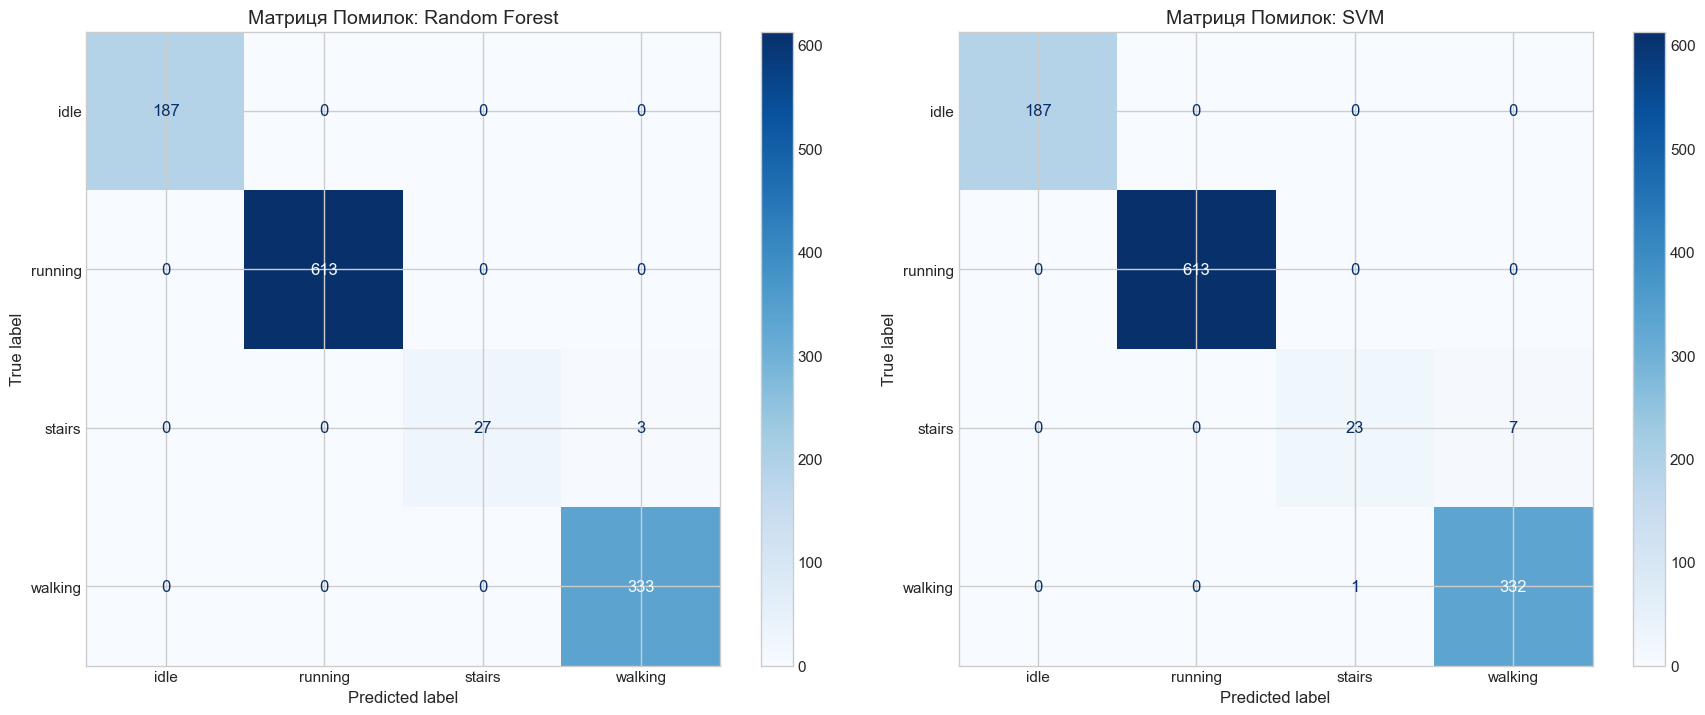

In [35]:
# Візуалізація матриць помилок (CONFUSION MATRIX)
# Це допоможе візуально зрозуміти, які класи моделі плутають.
# Отримуємо список класів для підписів
class_names = y_train.unique()
class_names.sort()

# Створюємо "полотно" для двох графіків
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 рядок, 2 колонки

# Матриця для Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=class_names)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title("Матриця Помилок: Random Forest", fontsize=14)

# Матриця для SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=class_names)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=class_names)
disp_svm.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title("Матриця Помилок: SVM", fontsize=14)

plt.tight_layout()
plt.show()